<a href="https://colab.research.google.com/github/dtabuena/Images/blob/main/Analyzing_Confocal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install python-bioformats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 40.3 MB 2.0 MB/s 
     |████████████████████████████████| 1.3 MB 23.7 MB/s 
     |████████████████████████████████| 132 kB 45.6 MB/s 
     |████████████████████████████████| 829 kB 34.3 MB/s 
     |████████████████████████████████| 9.1 MB 28.0 MB/s 
     |████████████████████████████████| 79 kB 7.3 MB/s 
     |████████████████████████████████| 140 kB 45.2 MB/s 
  Created wheel for python-javabridge: filename=python_javabridge-4.0.3-cp37-cp37m-linux_x86_64.whl size=1628201 sha256=625820eafbc403605a882f1031a3e52f7245841c44b45a7a6621ab91260581f3
  Stored in directory: /root/.cache/pip/wheels/63/7e/91/01b1bd8d29b4323834feb5cfec49b857fb212e6efc74ce103c
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=cb272bcac6a4b668ba1327cfafa76a25bb925bc135dc574b6d24c17c7d9de7f0
  Stored in directory: /root/.cache/pip/wheels/56/b0/

In [2]:
import numpy as np
import javabridge
import bioformats
import skimage
from skimage import filters
from matplotlib import pyplot as plt
import matplotlib
javabridge.start_vm(class_path=bioformats.JARS)

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [3]:
# !wget -O 'image.oir' 'https://www.dropbox.com/s/ec4squfg12j7tm7/RNF182_08-12-22_S001_CA3_40X_2XZOOM_1_.oir?dl=0'
# !wget -O 'image.oir' 'https://www.dropbox.com/s/8yiynglvcfww3cd/RNF182_08-12-22_S001_CA3_40X_2XZOOM_2.oir?dl=0'
# !wget -O 'image.oir' 'https://www.dropbox.com/s/ie3v5wdhbahaigj/Nell2_08-04-22_S001_DG_40X_2XZOOM_1.oir?dl=0'
# !wget -O 'image.oir' 'https://www.dropbox.com/s/tf88caoqox1z765/Nell2_08-04-22_S001_CA3_40X_2XZOOM_7.oir?dl=0'
!wget -O 'image.oir' 'https://www.dropbox.com/s/0597gxdoqco3aw6/MDGA2_08-25-22_S001_CA3_40X_2XZOOM_2.oir?dl=0'

--2022-09-23 20:05:25--  https://www.dropbox.com/s/0597gxdoqco3aw6/MDGA2_08-25-22_S001_CA3_40X_2XZOOM_2.oir?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/0597gxdoqco3aw6/MDGA2_08-25-22_S001_CA3_40X_2XZOOM_2.oir [following]
--2022-09-23 20:05:25--  https://www.dropbox.com/s/raw/0597gxdoqco3aw6/MDGA2_08-25-22_S001_CA3_40X_2XZOOM_2.oir
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucadd2ab8e9af7c7ffa434bc3e33.dl.dropboxusercontent.com/cd/0/inline/BtgHwWAsG3Eq6vGol0Hx86hyt2Ygwe54IT4O9I4okp92kunRtmy2KxmnAUFZXMLzJvkJ3JJnpzioB6rj8CpIR_ukIrDAZGGv3nYLotbXJutZ_Vrc6fplOaGZnUWJ8gWjyMW3oPxqtssGiJ8MpW659dEEtQXZ99JNHjoWZFOOh1Eyng/file# [following]
--2022-09-23 20:05:26--  https://ucadd2ab8e9af7c7ffa434bc3e33.dl.dropboxusercontent.com/

In [4]:
my_reader = bioformats.get_image_reader('my_image', 'image.oir')

c_dim = my_reader.rdr.getSizeC()
z_dim = my_reader.rdr.getSizeZ()
x_dim = my_reader.rdr.getSizeX()
y_dim = my_reader.rdr.getSizeY()
print(x_dim,y_dim,c_dim,z_dim)

image = np.empty([x_dim,y_dim,c_dim,z_dim])
for zi in range(z_dim):
    img_zi = my_reader.read(c=None, z=zi,rescale=True)
    image[:,:,:,zi] = img_zi


image_zproj = np.max(image,axis=3)
image = np.expand_dims(image_zproj, axis=-1)
print(image.shape)
for ci in range(image.shape[2]):
    cim = image[:,:,ci,:]
    max= np.percentile(cim.flatten(),95)
    cim = cim/max
    image[:,:,ci,:] = cim

800 800 3 7
(800, 800, 3, 1)


In [5]:
def new_colormap(start,stop,n=256):
    start = np.array(start)
    stop = np.array(stop)
    delta_ni = np.expand_dims((stop-start)/n,-1)
    ni = np.expand_dims(np.arange(n),-1)
    cmap_np = start + np.multiply(delta_ni.T,ni)
    return matplotlib.colors.ListedColormap(cmap_np)


green_map = new_colormap([0,0,0,1],[0,1,0,1])
red_map = new_colormap([0,0,0,1],[1,0,0,1])
blue_map = new_colormap([0,0,0,1],[0,0,1,1])

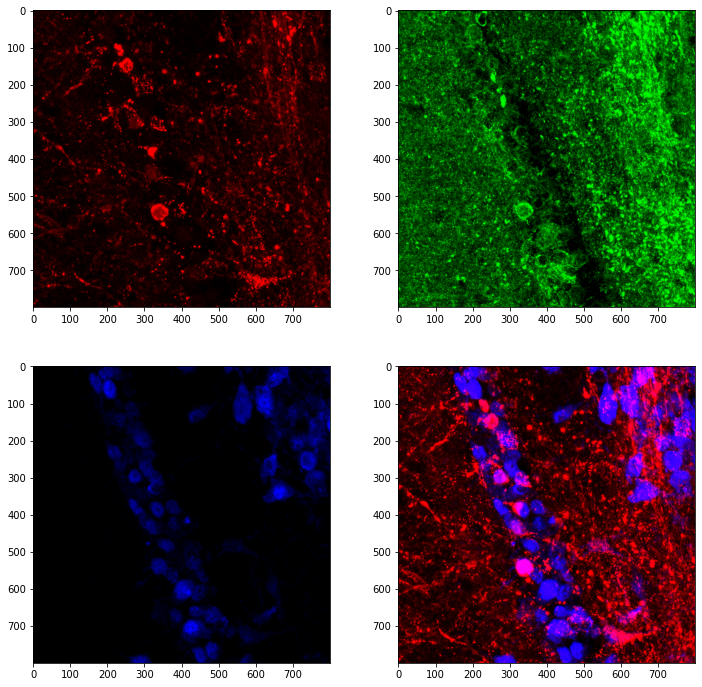

In [6]:
zi = 0

fig,ax = plt.subplots(2,2,figsize=[12,12])
ax = ax.flatten()
red_chan = image[:,:,1,:]
green_chan = image[:,:,0,:]
blue_chan = image[:,:,2,:]


composite = np.stack([red_chan,green_chan*0,blue_chan],axis=-2)

ax[0].imshow(red_chan[:,:,zi],cmap=red_map)
ax[1].imshow(green_chan[:,:,zi],cmap=green_map)
ax[2].imshow(blue_chan[:,:,zi],cmap=blue_map)
ax[3].imshow(composite[:,:,:,zi])
plt.show()


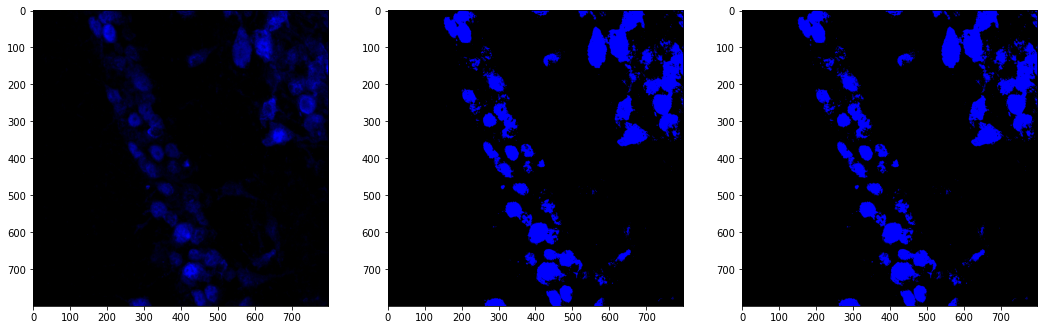

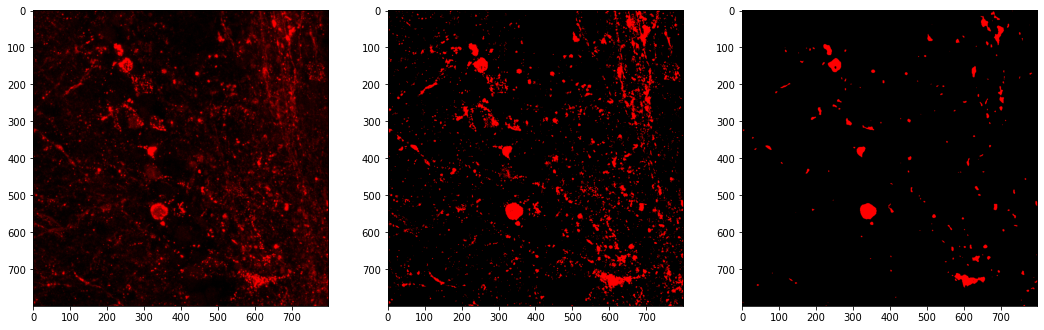

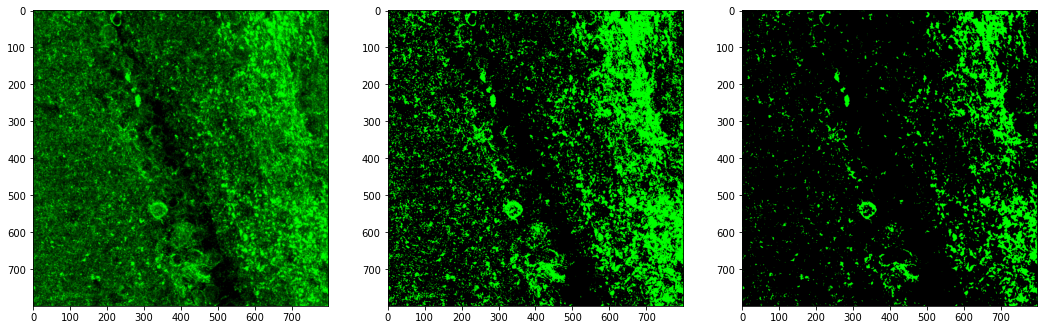

In [7]:
### threhold neun
zi = 0
zero_log = 1



image_c2 = image[:,:,2,:]

c2_vals = image_c2.flatten()
neu_thresh = filters.threshold_otsu(c2_vals)
neu_mask = image_c2>neu_thresh
neu_mask_b = filters.gaussian(neu_mask,.1)>0.8

fig,ax = plt.subplots(1,3,figsize=[18,6])
ax[0].imshow(image_c2[:,:,zi],cmap=blue_map)
ax[1].imshow(neu_mask[:,:,zi],cmap=blue_map)
ax[2].imshow(neu_mask_b[:,:,zi],cmap=blue_map)

# ax[0].grid(color='w', linestyle='-', linewidth=2)
# ax[1].grid(color='w', linestyle='-', linewidth=2)
# ax[2].grid(color='w', linestyle='-', linewidth=2)

plt.show()

############## Red Mask
image_c1 = image[:,:,1,:]
# image_c1 = filters.gaussian(image_c1,2)
c1_vals = image_c1.flatten()
mcher_thresh = filters.threshold_otsu(np.log(c1_vals+zero_log))
mcher_mask = image_c1>(filters.threshold_otsu(c1_vals))
# mcher_mask = np.log(image_c1+zero_log)>mcher_thresh*1
mcher_mask_b = filters.gaussian(mcher_mask,2)>0.8

fig,ax = plt.subplots(1,3,figsize=[18,6])
ax[0].imshow(image_c1[:,:,zi],cmap=red_map)
ax[1].imshow(mcher_mask[:,:,zi],cmap=red_map)
ax[2].imshow(mcher_mask_b[:,:,zi],cmap=red_map)

# ax[0].grid(color='w', linestyle='-', linewidth=2)
# ax[1].grid(color='w', linestyle='-', linewidth=2)
# ax[2].grid(color='w', linestyle='-', linewidth=2)

plt.show()

############## green Mask
image_c0 = image[:,:,0,:]
# image_c0 = filters.gaussian(image_c0,0)
c0_vals = image_c0.flatten()
# crisp_thresh = filters.threshold_otsu(np.log(c0_vals+zero_log))
crisp_mask = image_c0>(filters.threshold_otsu(c0_vals)*1)
# crisp_mask = np.log(image_c0+zero_log)>crisp_thresh*1
crisp_mask_b = filters.gaussian(crisp_mask,.4)>.99

fig,ax = plt.subplots(1,3,figsize=[18,6])
ax[0].imshow(image_c0[:,:,zi],cmap=green_map)
ax[1].imshow(crisp_mask[:,:,zi],cmap=green_map)
ax[2].imshow(crisp_mask_b[:,:,zi],cmap=green_map)

# ax[0].grid(color='w', linestyle='-', linewidth=2)
# ax[1].grid(color='w', linestyle='-', linewidth=2)
# ax[2].grid(color='w', linestyle='-', linewidth=2)
plt.show()

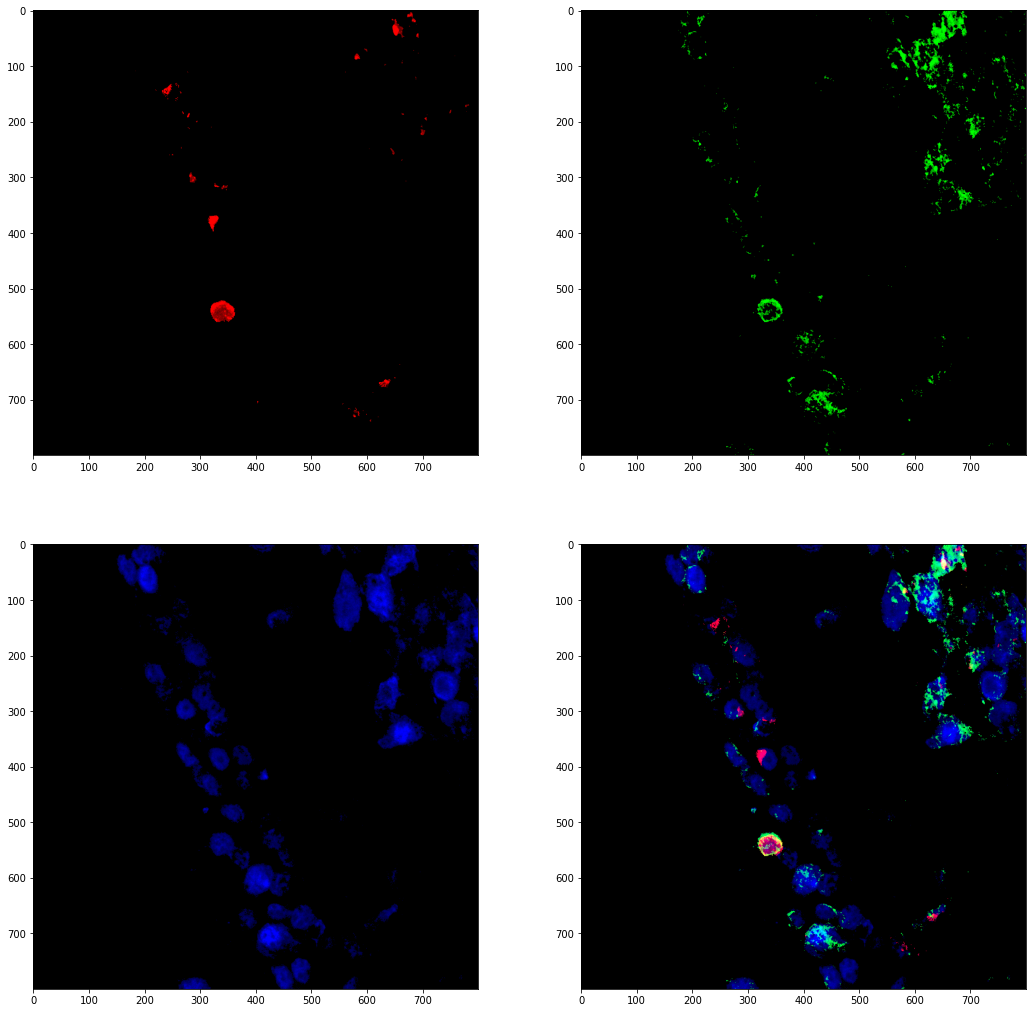

In [8]:
fig,ax = plt.subplots(2,2,figsize=[18,18])
ax = ax.flatten()
red_chan = mcher_mask_b*image[:,:,1]
red_chan = red_chan/np.max(red_chan.flatten())*neu_mask_b
green_chan = crisp_mask_b*image[:,:,0]
green_chan = green_chan/np.max(green_chan.flatten())*neu_mask_b
blue_chan = neu_mask_b*image[:,:,2]
blue_chan = blue_chan/np.max(blue_chan.flatten())*1
zi = 0
composite = np.stack([red_chan,green_chan,blue_chan],axis=-2)*1.0


ax[0].imshow(red_chan[:,:,zi],cmap=red_map)
ax[1].imshow(green_chan[:,:,zi],cmap=green_map)
ax[2].imshow(blue_chan[:,:,zi],cmap=blue_map)
ax[3].imshow(composite[:,:,:,zi])
plt.show()

In [ ]:
alexa-488
594
647

In [9]:
neu_mask_flat = neu_mask_b.flatten()
red_vals = red_chan.flatten()
green_vals = green_chan.flatten()

red_pix_in_cell = red_vals[neu_mask_flat]
green_pix_in_cell = green_vals[neu_mask_flat]

rpos_gpos = np.logical_and(red_pix_in_cell,green_pix_in_cell)
rpos_gneg = np.logical_and(red_pix_in_cell,np.logical_not(green_pix_in_cell))
rneg_gpos = np.logical_and(np.logical_not(red_pix_in_cell),green_pix_in_cell)
rneg_gneg = np.logical_and(np.logical_not(red_pix_in_cell),np.logical_not(green_pix_in_cell))


# rpos_gpos_count = np.sum(rpos_gpos)
# rpos_gneg_count = np.sum(rpos_gneg)
# rneg_gpos_count = np.sum(rneg_gpos)
# rneg_gneg_count = np.sum(rneg_gneg)



print('rpos_gpos',np.sum(rpos_gpos) )
print('rpos_gneg',np.sum(rpos_gneg) )
print('rneg_gpos',np.sum(rneg_gpos) )
print('rneg_gneg',np.sum(rneg_gneg) )
print('')

print('P(G+|R+) ',  np.round(np.sum(rpos_gpos) /(np.sum(rpos_gneg)+np.sum(rpos_gpos)) *100,1)  )
print('P(G-|R+) ',  np.round(np.sum(rpos_gneg) /(np.sum(rpos_gneg)+np.sum(rpos_gpos)) *100,1)  )

print('P(G+|R-) ',  np.round(np.sum(rneg_gpos) /(np.sum(rneg_gneg)+np.sum(rneg_gpos)) *100,1)  )
print('P(G-|R-) ',  np.round(np.sum(rneg_gneg) /(np.sum(rneg_gneg)+np.sum(rneg_gpos)) *100,1)  )
print('')

# print('P(G+) ', np.round(np.mean(green_pix_in_cell)*100,1))
# print('P(G-) ',  np.round(100-np.mean(green_pix_in_cell)*100,1))
# print('P(R+) ',  np.round(np.mean(red_pix_in_cell)*100,1))
# print('P(R-) ',  np.round(100-np.mean(red_pix_in_cell)*100,1))


# import scipy
# table = [[np.sum(rpos_gneg),np.sum(rpos_gpos)],[np.sum(rneg_gneg),np.sum(rneg_gpos)] ]
# odds_ratio, p_val = scipy.stats.fisher_exact(table, alternative='two-sided')
# print('p=',p_val)

rpos_gpos 1234
rpos_gneg 1927
rneg_gpos 10366
rneg_gneg 56080

P(G+|R+)  39.0
P(G-|R+)  61.0
P(G+|R-)  15.6
P(G-|R-)  84.4

